<h3>Introducción</h3>
En este Notebook se utilizará el código <a href = "https://github.com/feos-org/feos"> $\mathrm{FeO_s}$</a> v0.3.0 para obtener parámetros SAFT que luego se utilizarán para modelar la adsorción de gases mediante la Teoría del Funcional de la Densidad Clásica. Para esto se necesita tener instalado el código $\mathrm{FeO_s}$, así como, numpy y pandas.

In [1]:
from feos.si import *
from feos.pcsaft import *
from feos.eos import *

import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

Lo primero que hay que hacer es definir algunas funciones que servirán más tarde. A continuación, se define la EOS Peng-Robinson que servirá para comparar los resultados obtenidos con PC-SAFT.

In [2]:
SQRT2 = np.sqrt(2)

class PengRobinson: 
    def __init__(
        self, critical_temperature, critical_pressure, 
        acentric_factor, molar_weight, delta_ij=None
    ):

        self.n = len(critical_temperature)
        if len(set((
            len(critical_temperature), 
            len(critical_pressure), 
            len(acentric_factor)
        ))) != 1:
            raise ValueError("Error")
        
        self.tc = critical_temperature / KELVIN
        self.pc = critical_pressure / PASCAL
        self.omega = acentric_factor
        self.mw = molar_weight / GRAM * MOL

        self.a_r = (0.45724 * critical_temperature**2 * RGAS 
                    / critical_pressure / ANGSTROM**3 / NAV / KELVIN)
        self.b = (0.07780 * critical_temperature * RGAS 
                  / critical_pressure / ANGSTROM**3 / NAV)
        self.kappa = (0.37464 
                      + (1.54226 - 0.26992 * acentric_factor) * acentric_factor)
        self.delta_ij = (np.zeros((self.n, self.n)) 
                         if delta_ij is None else delta_ij)
        
    def helmholtz_energy(self, state):
        n = np.sum(state.moles)
        x = state.molefracs
        tr = 1.0 / self.tc * state.temperature
        ak = ((1.0 - np.sqrt(tr)) * self.kappa + 1.0)**2 * self.a_r
        ak_mix = 0.0
        if self.n > 1:
            for i in range(self.n):
                for j in range(self.n):
                    ak_mix += (np.sqrt(ak[i] * ak[j]) 
                               * (x[i] * x[j] * (1.0 - self.delta_ij[i, j])))
        else:
            ak_mix = ak[0]
        b = np.sum(x * self.b)
        v = state.volume
        rho = np.sum(state.partial_density)
        a = n * (-np.log(1.0 - b * rho) 
                 - ak_mix / (b * SQRT2 * 2.0 * state.temperature) 
                 * np.log((SQRT2 - 1.0 + b * rho) / (SQRT2 + 1.0 - b * rho)))
        return a
    
    def components(self) -> int: 
        return self.n
    
    def subset(self, i: [int]):
        if self.n > 1:
            tc = self.tc[i] 
            pc = self.pc[i]
            mw = self.mw[i]
            omega = self.omega[i]
            return PyPengRobinson(
                SIArray1(tc * KELVIN), 
                SIArray1(pc * PASCAL), 
                omega, 
                SIArray1(mw * GRAM / MOL)
            )
        else:
            return self
        
    def molar_weight(self) -> SIArray1:
        return SIArray1(self.mw * GRAM / MOL)
    
    def max_density(self, moles:[float]) -> float:
        b = np.sum(moles * self.b) / np.sum(moles);
        return 0.9 / b 

Luego, se define una funcion "Trozar" que sirve simplemente para facilitar el uso de elementos muy grandes y manejarlos con Pandas.

In [3]:
def Trozar(vec, num):  # corta vectores (vec) en "num" pedazos
    avg = len(vec) / float(num)
    out = []
    last = 0.0
    while last < len(vec):
        out.append(vec[int(last):int(last + avg)])
        last += avg
    return out

<h3>Hidrógeno</h3>
Para ajustar el modelo y comparar con resultados verídicos se utilizan los datos extraídos de <a href = "https://webbook.nist.gov/cgi/fluid.cgi?ID=C1333740&Action=Page"> NIST</a>.

In [4]:
# Importar propiedades del H2 (NIST)
df = pd.read_csv('/home/felipe/feos/examples/Codes/Puros/H2/H2_Supercritico2.csv',header= None)

Temp0 = df[0] # Temperatura en K
Pres1 = df[1] # Presion en MPa
Dens1 = df[2] # Densidad en kg/m3
Pres2 = df[3] # Presion en MPa
Dens2 = df[4] # Densidad en kg/m3
Pres3 = df[5] # Presion en MPa
Dens3 = df[6] # Densidad en kg/m3
Pres4 = df[7] # Presion en MPa
Dens4 = df[8] # Densidad en kg/m3
Pres5 = df[9] # Presion en MPa
Dens5 = df[10] # Densidad en kg/m3
DensidadNIST=np.row_stack((Dens1,Dens2,Dens3,Dens4,Dens5))
#df.head()

Luego, se definen los parámetros necesarios para la ecuación Peng-Robinson extraídos de <a href = "https://webbook.nist.gov/cgi/cbook.cgi?ID=C1333740&Mask=4"> NIST</a> y <a href = "https://www.chemeo.com/cid/17-951-7/Hydrogen"> Chemeo</a>. Con estos parámetros se puede iniciar "eos", para trabajar con estas funciones hay varios tutoriales en la carpeta <a href = "https://github.com/feos-org/feos/blob/main/examples/core_user_defined_eos.ipynb"> examples</a> del código $\mathrm{FeO_s}$.

In [5]:
MW =2.016                               # g/mol
tc = SIArray1(33.18 * KELVIN)
pc = SIArray1(1300000 * PASCAL)
omega = np.array([-0.2160])
molar_weight = SIArray1(MW * GRAM / MOL)

pr = PengRobinson(tc, pc, omega, molar_weight)
eos = EquationOfState.python(pr)

Despues se definieron las condiciones de Temperatura y Presion donde se harán los cálculos. Para tener un gráfico continuo se usa la temperatura como un vector linspace.

In [6]:
Temperatura = np.linspace(50, 300, 41).tolist()   # en °K
Presion     = [20,40,50,100,200]                  # en bar

Con Temperatura y Presión definidas se pueden obtener las densidades del hidrógeno mediante la EOS Peng-Robinson de la siguiente forma.

In [7]:
densidades=[]                                        # en mol/m3
for i in Presion:
        for j in Temperatura:
            state_npt = State(eos, temperature=j*KELVIN, pressure=i*BAR)
            densi = np.multiply(state_npt.density*METER**3/MOL,MW/1000)
            densidades.append(densi)
DensidadPR=Trozar(densidades, len(Presion))          # en kg/m3

Se define la función "FUNC" para determinar las densidades del hidrógeno mediante PC-SAFT . De igual forma, para aprender a trabajar con estas funciones se recomienda revisar los ejemplos entregados en <a href = "https://github.com/feos-org/feos/tree/main/examples"> examples</a>.


In [8]:
def FUNC(m,s,e):
    identifier = Identifier(name='hydrogen')
    psr = PcSaftRecord(m, s, e)
    hydrogen = PureRecord(identifier, molarweight=MW, model_record=psr)
    parameters = PcSaftParameters.new_pure(hydrogen)
    pcsaftt = EquationOfState.pcsaft(parameters)
    
    # Obtener curvas de PC-SAFT
    densid=[]                                  # en mol/m3
    for i in Presion:
            for j in Temperatura:
                state_npt = State(pcsaftt, temperature=j*KELVIN, pressure=i*BAR)
                densi = state_npt.density
                densid.append(densi*METER**3/MOL)
    Densidad=Trozar(densid, len(Presion))
    DensidadSAFT=np.multiply(Densidad,MW/1000) # Densidad en kg/m3
    return DensidadSAFT

Una vez definido el cálculo de densidades, la EOS PC-SAFT se puede usar directamente. Para este caso ya se determinaron los parámetros SAFT $m$ (m), $\sigma$ (s) y $\varepsilon$ (e), por lo que simplemente llamando a la función se pueden graficar los resultados. El método con el que se determinaron los parámetros óptimos se muestra mas adelante.

In [9]:
m=1
s=3.105
e=28.25

DensidadSAFT = FUNC(m,s,e)

Aquí se grafican los resultados de ambas EOS comparandolas con los datos de NIST.

(0.0, 80.0)

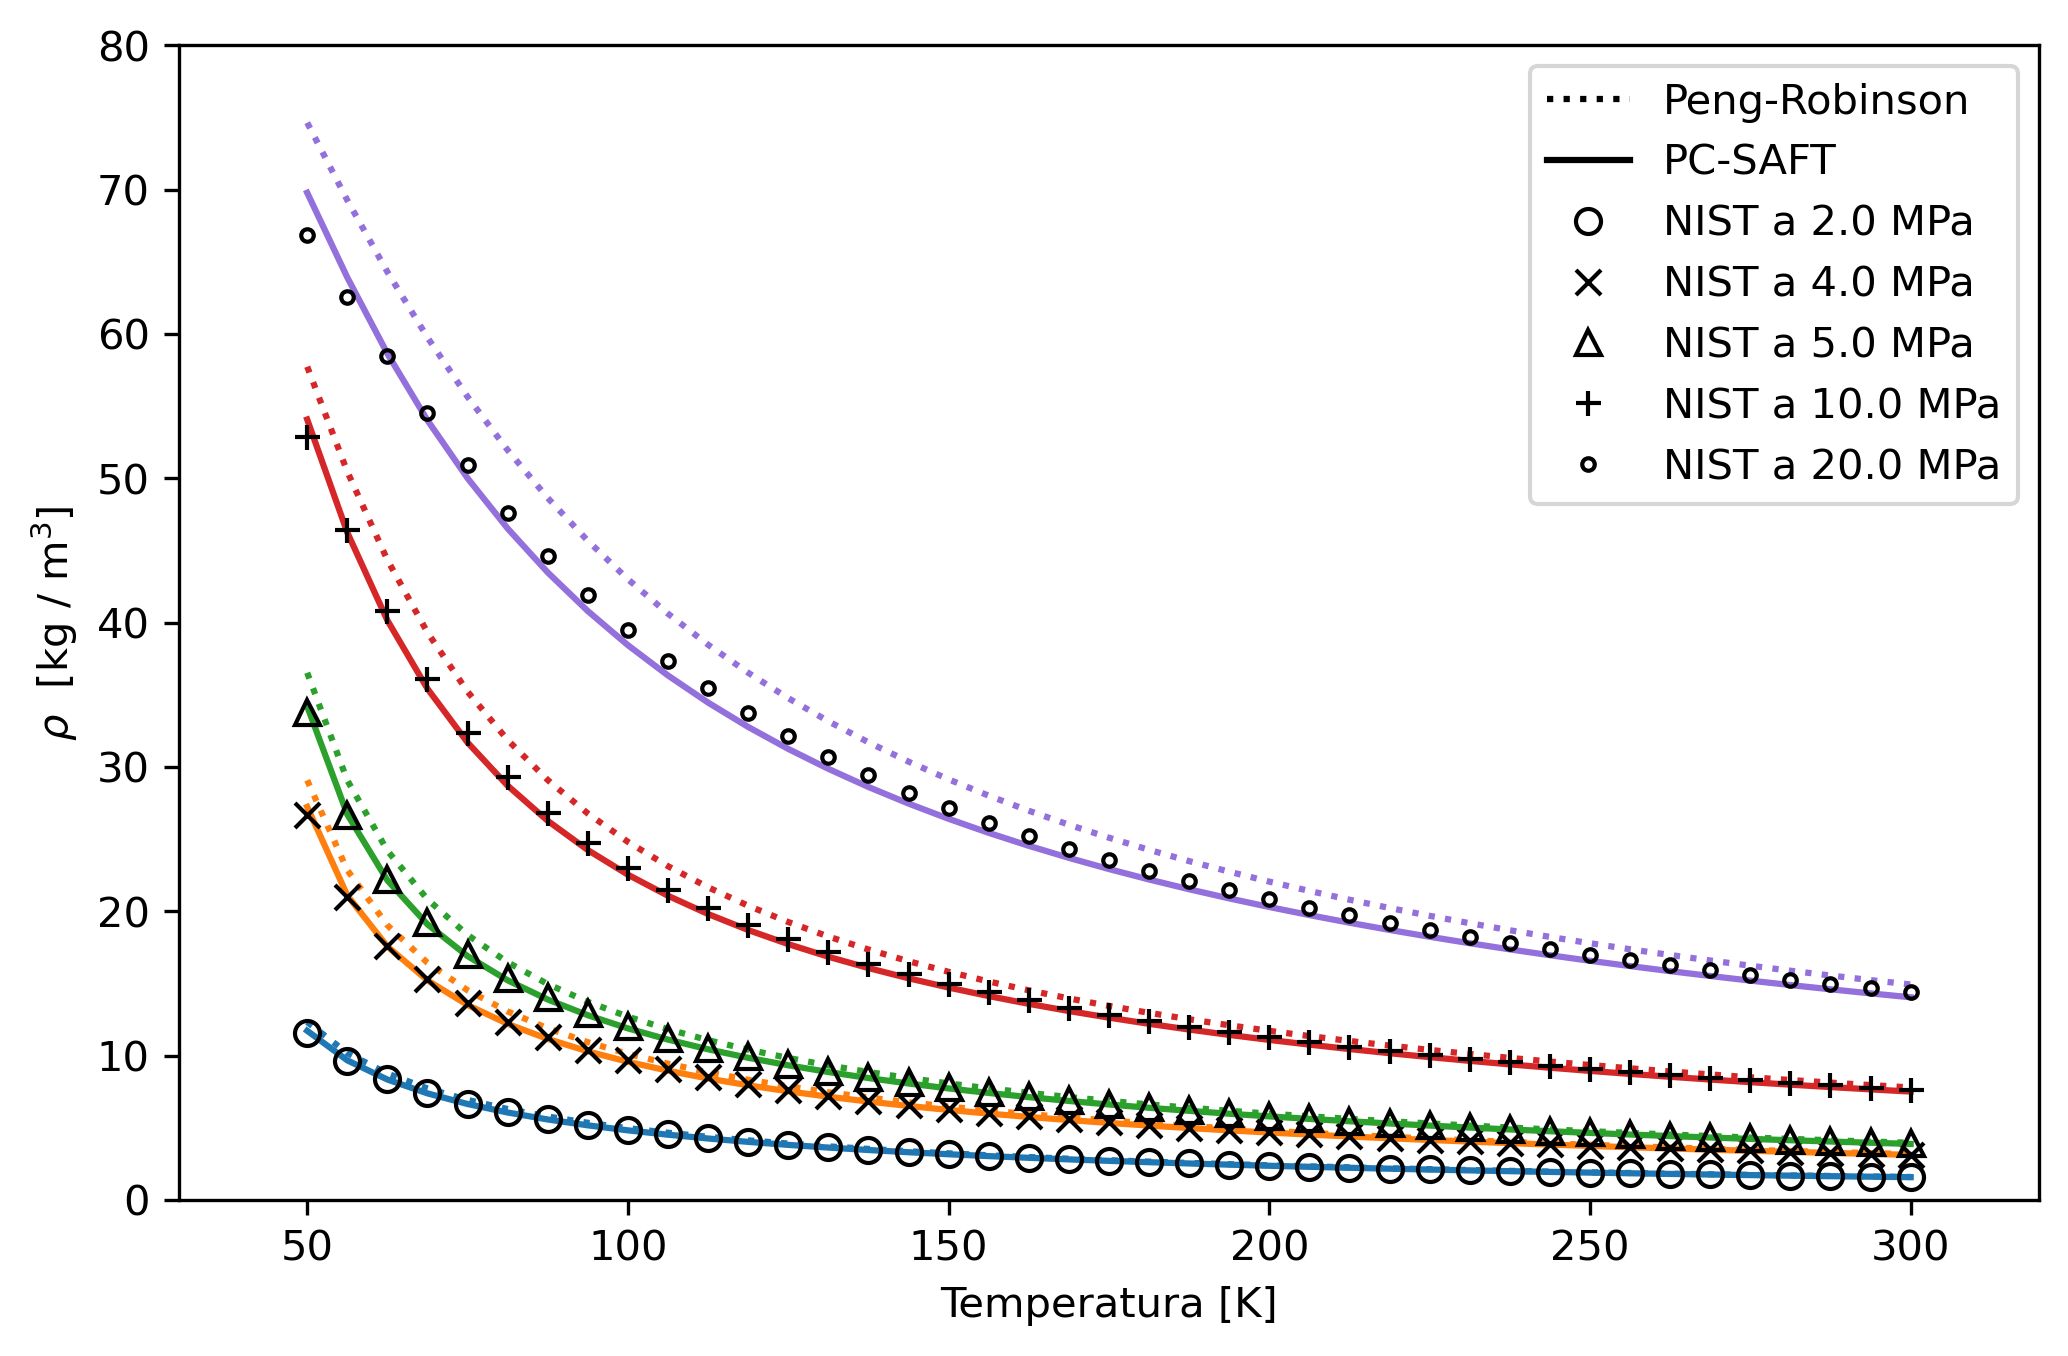

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(8, 5), dpi=300)

colores = ["tab:blue", "tab:orange", "tab:green", "tab:red", "mediumpurple"]
marcador= ["o", "x", "^", "+","."]
naux = 0

plt.plot(-1,-1, color="k", label='Peng-Robinson', linestyle="dotted")  #Simplemente para la leyenda
plt.plot(-1,-1, color="k", label='PC-SAFT', linestyle="solid")
for j in range(len(Presion)):
    
    plt.plot(Temperatura,DensidadPR[j], color=colores[naux], linestyle="dotted")
    
    plt.plot(Temperatura,DensidadSAFT[j], color=colores[naux])
      
    plt.plot(Temp0,DensidadNIST[j]*MW, color="k", label='NIST a {} MPa'.format(Presion[j]/10),
            marker=marcador[naux], linestyle="None", mfc="None")
             
    naux+=1
# Grafico
plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"Temperatura [K]")
plt.ylabel(r"$\rho$  [kg / m$^3$]")
plt.xlim(30, 320)
plt.ylim(0, 80)

<h3>Búsqueda de parámetros SAFT</h3>
A continuación se muestra un método simple para obtener los parámetros usados anteriormente. El método da buenos resultados, pero no es el más eficiente y puede ser mejorado. Se basa en encontrar el valor mínimo de una funcion objetivo (mínimos cuadrados) en un espacio de búsqueda. Todas los resultados dentro del espacio de búsqueda son computados, guardados en formato Pandas y luego dentro de ese DataFrame se encuentra el valor mínimo. Para despues determinar los parámetros con los que se obtuvo ese mínimo de la función objetivo.

En este caso, se optó por utilizar un valor $m$ de 1, pues entregaba mejores resultados. Además se muestra un rango de búsqueda acotado para facilitar el cálculo.


In [11]:
# Armar el espacio de busqueda
me = np.linspace(1, 1, 3).tolist()
se = np.linspace(3.1, 3.15, 11).tolist()
ee = np.linspace(28, 28.5, 11).tolist()

print(me)
print(se)
print(ee)

[1.0, 1.0, 1.0]
[3.1, 3.105, 3.11, 3.115, 3.12, 3.125, 3.13, 3.135, 3.14, 3.145, 3.15]
[28.0, 28.05, 28.1, 28.15, 28.2, 28.25, 28.3, 28.35, 28.4, 28.45, 28.5]


Se define la función a minimizar

In [12]:
%%time
AUX=[]
DenN=DensidadNIST*MW
for i in me:
    for j in se:
        for k in ee:
            DenS = FUNC(i,j,k)
            FO = np.sum(((DenS[0]-DenN[0])**2))+np.sum(((DenS[1]-DenN[1])**2))+np.sum(((DenS[2]-DenN[2])**2))+np.sum(((DenS[3]-DenN[3])**2))+np.sum(((DenS[4]-DenN[4])**2))
            AUX.append(FO)

CPU times: user 7.23 s, sys: 19.5 ms, total: 7.25 s
Wall time: 7.56 s


Se guardan los resultados y se buscan los parámetros SAFT con los que se obtiene el mínimo de la función.

In [13]:
# Guardar resultados
Matriz= Trozar(AUX, len(se)*len(me))
DAT   = pd.DataFrame(Matriz, index=None).T

# Buscar el valor de epsilon
Pepsilon=DAT[DAT.eq(min(AUX)).any(1)].idxmin('columns').index.tolist()[0]      # Posicion de epsilon
Epsilon=ee[Pepsilon]
# Buscar el valor de m
ncm=DAT[DAT.eq(min(AUX)).any(1)].idxmin('columns').tolist()[0]     # Es el numero de la columna donde esta el minimo
lista=range(ncm)   # Crea una lista desde 0 hasta el numero de la columna donde esta el minimo
n = len(se)        # Cantidad de valores que debe contener cada trozo de "lista"
Trozos = [lista[i * n:(i + 1) * n] for i in range((len(lista) + n - 1) // n )] #trozos de "lista" cortados
ntr=len(Trozos)                                                                # numero de trozos
EME=me[ntr-1]
# Buscar el valor de sigma
si=ncm-min(Trozos[ntr-1])                                                      # Posicion de sigma
Sigma=se[si]
print('El valor de m es:',EME)
print('El valor de sigma es:',Sigma)
print('El valor de epsilon es:',Epsilon)

El valor de m es: 1.0
El valor de sigma es: 3.105
El valor de epsilon es: 28.25


In [14]:
# Testear que el óptimo es correcto
m=EME
s=Sigma
e=Epsilon

TEST = FUNC(m,s,e)
FO = np.sum(((TEST[0]-DenN[0])**2))+np.sum(((TEST[1]-DenN[1])**2))+np.sum(((TEST[2]-DenN[2])**2))+np.sum(((TEST[3]-DenN[3])**2))+np.sum(((TEST[4]-DenN[4])**2))
print(min(AUX)==FO)

True


Finalmente, se grafican nuevamente.

(0.0, 80.0)

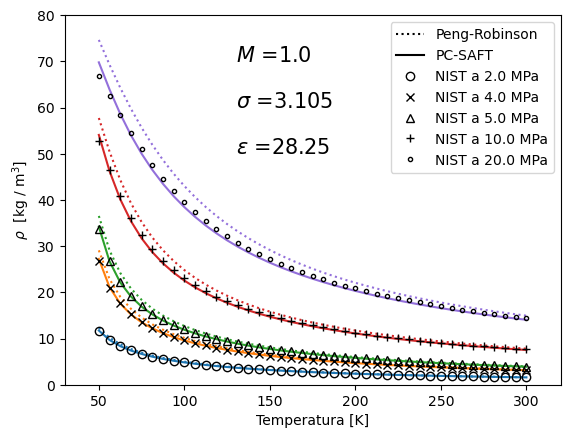

In [15]:
colores = ["tab:blue", "tab:orange", "tab:green", "tab:red", "mediumpurple"]
marcador= ["o", "x", "^", "+","."]
naux = 0

plt.plot(-1,-1, color="k", label='Peng-Robinson', linestyle="dotted")
plt.plot(-1,-1, color="k", label='PC-SAFT', linestyle="solid")
for j in range(len(Presion)):
    
    plt.plot(Temperatura,DensidadPR[j], color=colores[naux], linestyle="dotted")
    
    plt.plot(Temperatura,TEST[j], color=colores[naux])
      
    plt.plot(Temp0,DensidadNIST[j]*MW, color="k", label='NIST a {} MPa'.format(Presion[j]/10),
            marker=marcador[naux], linestyle="None", mfc="None")
             
    naux+=1

eq1 = (r"$M$ ={}".format(m))
eq2 = (r"$\sigma$ ={}".format(s))
eq3 = (r"$\varepsilon$ ={}".format(e))
plt.text(130, 70, eq1, color="k", fontsize=15) #horizontal, vertical
plt.text(130, 60, eq2, color="k", fontsize=15) #horizontal, vertical
plt.text(130, 50, eq3, color="k", fontsize=15) #horizontal, vertical

# Grafico
plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"Temperatura [K]")
plt.ylabel(r"$\rho$  [kg / m$^3$]")
plt.xlim(30, 320)
plt.ylim(0, 80)